In [1]:
!apt-get install openslide-tools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


In [2]:
pip install pydicom

In [3]:
!apt-get install python3-openslide

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-openslide is already the newest version (1.1.1-2ubuntu4).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


In [4]:
!pip install openslide-python

##Importing All the required Libraries

In [5]:
#Importing necessary libraries
import pylab
import csv
import random
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
import skimage.exposure


import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom 
%matplotlib inline 
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import multiprocessing
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import util
from skimage import transform
from google.colab import drive
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#Mounting the drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [80]:
#Set the project path 
project_path = '/content/drive/My Drive/AIML/Datasets/'
os.chdir(project_path)

In [81]:
#Loading the images
images_path = ("/content/drive/My Drive/AIML/Datasets/stage_2_train_images")


##Reading the data using Pydicom

In [82]:
data1 = pydicom.read_file("/content/drive/My Drive/AIML/Datasets/filtered_train_images/2d2679da-35e6-49fb-a703-52aadee243ea.dcm")
img_array = data1.pixel_array
img_array.shape

(1024, 1024)

##Load the data
#Loading the tabular data. There are two files:

1)Detailed class info
2)Train labels

In [83]:
class_info_df = pd.read_csv(project_path+'stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(project_path+'stage_2_train_labels.csv')

In [84]:
#Viewing sample from train_labels_df
train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [85]:
#Viewing sample from class_info_df
class_info_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [86]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


##Considering the Class in Class_info, getting the count of the 3 Catogories
1.No Lung Opacity / Not Normal

2.Lung Opacity

3.Normal

In [87]:
class_info_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [88]:
train_labels_df.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [89]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [90]:
class_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [91]:
train_labels_df.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [92]:
class_info_df.isnull().sum()

patientId    0
class        0
dtype: int64

##Image Data Analysis

In [20]:
dicom_file_path = os.path.join(project_path,"filtered_train_images/",'2d2679da-35e6-49fb-a703-52aadee243ea.dcm')#samplePatientID)
dicom_file_dataset = pydicom.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.27376.1517874478.111287
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.27376.1517874478.111287
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [21]:
sample_image = dicom_file_dataset.pixel_array
sample_image

array([[  0,  10,  15, ...,  17,  17,  17],
       [  0,  18,  18, ...,  17,  17,  17],
       [  0,   7,  16, ...,  17,  17,  17],
       ...,
       [  0,  93, 165, ..., 126, 123, 121],
       [  2,  59, 106, ...,  97,  95,  95],
       [  0,   0,   3, ...,   0,   0,   0]], dtype=uint8)

In [22]:
sample_image.shape

(1024, 1024)

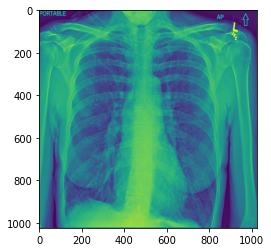

In [23]:
plt.imshow(sample_image)

In [93]:
# The image has information about the Patient's Age and Sex that can be used to understand the data distribution. 

def image_info(dataset):
    _id = dataset.PatientID
    _age = dataset.PatientAge
    _sex = dataset.PatientSex
    _pixel_row = dataset.Rows
    _pixel_cols = dataset.Columns 
   # _pixel_array =  dataset.pixel_array                              
    return _id, _age, _sex, _pixel_row, _pixel_cols

In [94]:
from tqdm import tqdm
responses = []

for file_name in tqdm(os.listdir(images_path)):
    
    file_path = os.path.join(images_path, file_name)
    dataset = pydicom.dcmread(file_path)

    responses.append(image_info(dataset))



100%|██████████| 16630/16630 [01:33<00:00, 177.60it/s]


In [95]:
train_demo_df

,patientId,patientAge,patientSex,rows,cols
0,9fd1cbef-7996-4414-ab5b-1c68253b7b8b,46,F,1024,1024
1,9fd1c79a-428c-4fb0-af04-bfdaecf1d579,47,M,1024,1024
2,9fca525c-4b1c-4308-8485-5fff76a87ce6,48,F,1024,1024
3,9fdcaddc-c6af-4a0f-8a63-6164c6f48518,50,F,1024,1024
4,9fd3c2a2-47c8-437d-a05d-e893fee688c9,46,M,1024,1024
...,...,...,...,...,...
16625,08cf3d00-57e7-49c2-ae30-7994da5cfa86,48,M,1024,1024
16626,08cf13be-3988-4a73-b5b6-b9b09e1daab8,66,M,1024,1024
16627,08d0531a-b5c3-4677-94f1-a48101ed3e06,60,M,1024,1024
16628,08b9ee23-ff64-4494-b293-5e43f3de3453,62,F,1024,1024


In [96]:
train_demo_df = pd.DataFrame()
ids = []
ages = []
sex = []
rows = []
cols = []
#pixel_array = []
for response in tqdm(responses):
    _id, _age, _sex, _pixel_row, _pixel_cols  = response
    ids.append(_id)
    ages.append(_age)
    sex.append(_sex)
    rows.append(_pixel_row)
    cols.append(_pixel_cols)
    #img_dataset.append(_pixel_array)

100%|██████████| 16630/16630 [00:00<00:00, 820468.11it/s]


In [97]:
train_demo_df['patientId'] = pd.Series(ids)
train_demo_df['patientAge'] = pd.Series(ages, dtype='int')
train_demo_df['patientSex'] = pd.Series(sex)
train_demo_df['rows'] = pd.Series(rows)
train_demo_df['cols'] = pd.Series(cols)


In [98]:
train_demo_df['patientId'] 

0        9fd1cbef-7996-4414-ab5b-1c68253b7b8b
1        9fd1c79a-428c-4fb0-af04-bfdaecf1d579
2        9fca525c-4b1c-4308-8485-5fff76a87ce6
3        9fdcaddc-c6af-4a0f-8a63-6164c6f48518
4        9fd3c2a2-47c8-437d-a05d-e893fee688c9
                         ...                 
16625    08cf3d00-57e7-49c2-ae30-7994da5cfa86
16626    08cf13be-3988-4a73-b5b6-b9b09e1daab8
16627    08d0531a-b5c3-4677-94f1-a48101ed3e06
16628    08b9ee23-ff64-4494-b293-5e43f3de3453
16629    08dd362a-d27b-47bd-a763-5e07f49f4584
Name: patientId, Length: 16630, dtype: object

In [99]:
sex_map = {'F': 0, 'M': 1}
train_demo_df['patientSex'] = train_demo_df['patientSex'].replace(sex_map).astype('int')

In [100]:
train_demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16630 entries, 0 to 16629
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patientId   16630 non-null  object
 1   patientAge  16630 non-null  int64 
 2   patientSex  16630 non-null  int64 
 3   rows        16630 non-null  int64 
 4   cols        16630 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 649.7+ KB


In [101]:
train_demo_df['cols'].value_counts()

1024    16630
Name: cols, dtype: int64

In [102]:
train_demo_df['rows'].value_counts()

1024    16630
Name: rows, dtype: int64

##Merge train and class detail info data

Let's merge now the two CSV datasets with the metadata obtained from images, using Patient ID as the merge criteria.

In [112]:
#Merging both the CSVs and the image metadata into a single dataframe

train_demo_df = pd.merge(left=train_demo_df, right=class_info_df, left_on='patientId', right_on='patientId')

In [111]:
train_labels_df.sample(5)

,patientId,x,y,width,height,Target
27366,f30e0c38-d83e-4ce4-bfcd-c72211d1fd56,NaN,NaN,NaN,NaN,0
22802,cdacf2e4-0ee9-4989-91b3-a2d8ce266414,NaN,NaN,NaN,NaN,0
11358,7638c224-6103-4774-8254-73f3b394779d,258.0,561.0,177.0,130.0,1
3291,376a6f4e-a470-48e7-9092-b6179f296e46,568.0,292.0,265.0,319.0,1
26613,ed0ed8ae-2897-42fe-af08-ec88c69ce1b3,NaN,NaN,NaN,NaN,0


In [113]:
# Viewing a few records from the merged dataset
train_demo_df.sample(5)

,patientId,patientAge,patientSex,rows,cols,x,y,width,height,Target,class
15501,38dee80a-f2e3-41f4-8a72-1f89f4a9c003,62,0,1024,1024,572.0,480.0,199.0,255.0,1,Lung Opacity
6593,849217ad-5cb2-4a87-9796-420b69722b14,60,0,1024,1024,680.0,441.0,214.0,284.0,1,Lung Opacity
8291,6cb97627-f00e-4fad-a90e-f9f09ef28d24,66,1,1024,1024,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
720,a4761e68-6192-4d9c-994f-21bb2ff7b822,72,1,1024,1024,NaN,NaN,NaN,NaN,0,Normal
4190,874b936d-24b3-4c55-9ee6-d4974a89bf99,66,0,1024,1024,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [114]:
print("Unique patientId in  train_class_df: ", train_demo_df['patientId'].nunique())

Unique patientId in  train_class_df:  16610


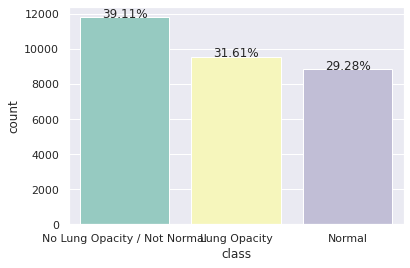

In [115]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

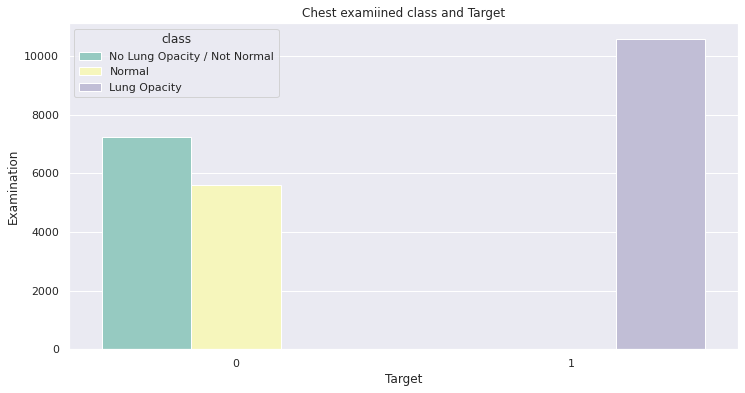

In [116]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_demo_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Examination': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Examination',hue='class',data=df, palette='Set3')
plt.title("Chest examiined class and Target")
plt.show()

In [117]:
train_demo_df["class"].value_counts()

Lung Opacity                    10593
No Lung Opacity / Not Normal     7254
Normal                           5613
Name: class, dtype: int64

In [118]:
train_demo_df.Target.value_counts()

0    12867
1    10593
Name: Target, dtype: int64

In [119]:
class_map = {'Lung Opacity': 0, 'No Lung Opacity / Not Normal': 1, 'Normal': 2}
train_demo_df['class'] = train_demo_df['class'].replace(class_map).astype('int')

In [120]:
print(f"Train labels -  rows: {train_demo_df.shape[0]}, columns: {train_demo_df.shape[1]}")

Train labels -  rows: 23460, columns: 11


##Graphical Representation on the Class_Info

Chest Examine with Class and Target

## Understading the data set plots with a bar chart

<Figure size 432x288 with 0 Axes>

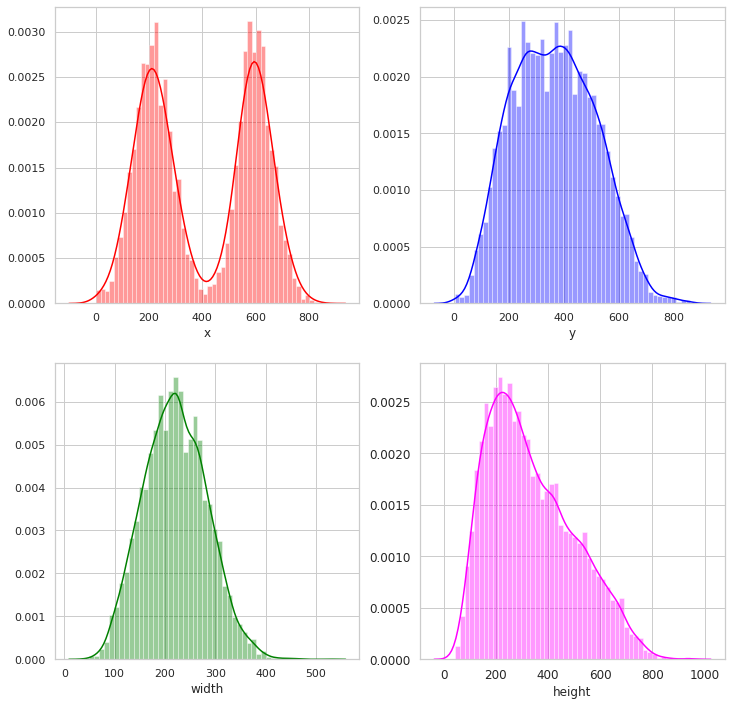

In [121]:
target1 = train_demo_df[train_demo_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

##Unique number Patients count from Train CLass

In [122]:
print("Unique patientId in  train_demo_df: ", train_demo_df['patientId'].nunique())

Unique patientId in  train_demo_df:  16610


## Meta Data information from DICOM data

## Train data

We will parse the DICOM meta information and add it to the train dataset.

##Categorizing the data based on age, into groups of 0-20, 20-40, 40-60 and above 60.

In [137]:
train_demo_df

,patientId,patientAge,patientSex,rows,cols,x,y,width,height,Target,class,age_group
0,9fd1cbef-7996-4414-ab5b-1c68253b7b8b,46,0,1024,1024,NaN,NaN,NaN,NaN,0,1,NaN
1,9fd1c79a-428c-4fb0-af04-bfdaecf1d579,47,1,1024,1024,NaN,NaN,NaN,NaN,0,2,NaN
2,9fca525c-4b1c-4308-8485-5fff76a87ce6,48,0,1024,1024,NaN,NaN,NaN,NaN,0,1,NaN
3,9fdcaddc-c6af-4a0f-8a63-6164c6f48518,50,0,1024,1024,NaN,NaN,NaN,NaN,0,1,NaN
4,9fd3c2a2-47c8-437d-a05d-e893fee688c9,46,1,1024,1024,NaN,NaN,NaN,NaN,0,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23455,08cf3d00-57e7-49c2-ae30-7994da5cfa86,48,1,1024,1024,NaN,NaN,NaN,NaN,0,1,NaN
23456,08cf13be-3988-4a73-b5b6-b9b09e1daab8,66,1,1024,1024,NaN,NaN,NaN,NaN,0,1,NaN
23457,08d0531a-b5c3-4677-94f1-a48101ed3e06,60,1,1024,1024,NaN,NaN,NaN,NaN,0,2,NaN
23458,08b9ee23-ff64-4494-b293-5e43f3de3453,62,0,1024,1024,NaN,NaN,NaN,NaN,0,2,NaN


##Categorizing the data based on age, into groups of 0-20, 20-40, 40-60 and above 60.

In [123]:
filtered_target = train_demo_df['Target'] == 1
healthy_target = train_demo_df['Target'] == 0

filtered_df = train_demo_df[filtered_target]
healthy_df = train_demo_df[healthy_target]

In [124]:
filtered_target = train_demo_df
filtered_target['age_group'] = np.nan

In [138]:
filtered_target['age_group'][filtered_target.patientAge < 60] = '40-60'
filtered_target['age_group'][filtered_target.patientAge <40 ] = '20-40'
filtered_target['age_group'][filtered_target.patientAge < 20  ] = '0-20'
filtered_target['age_group'][filtered_target.patientAge >= 60] = 'above 60'

In [139]:
filtered_target.head(5)

,patientId,patientAge,patientSex,rows,cols,x,y,width,height,Target,class,age_group
0,9fd1cbef-7996-4414-ab5b-1c68253b7b8b,46,0,1024,1024,NaN,NaN,NaN,NaN,0,1,40-60
1,9fd1c79a-428c-4fb0-af04-bfdaecf1d579,47,1,1024,1024,NaN,NaN,NaN,NaN,0,2,40-60
2,9fca525c-4b1c-4308-8485-5fff76a87ce6,48,0,1024,1024,NaN,NaN,NaN,NaN,0,1,40-60
3,9fdcaddc-c6af-4a0f-8a63-6164c6f48518,50,0,1024,1024,NaN,NaN,NaN,NaN,0,1,40-60
4,9fd3c2a2-47c8-437d-a05d-e893fee688c9,46,1,1024,1024,NaN,NaN,NaN,NaN,0,2,40-60


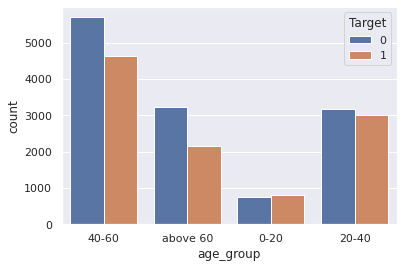

In [140]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="age_group", hue="Target", data=filtered_target)

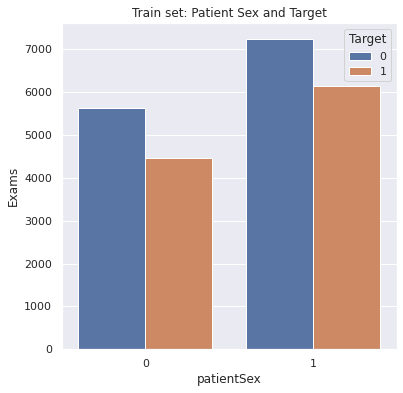

In [141]:
tmp = train_demo_df.groupby(['Target', 'patientSex'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target', 'patientSex']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, ax = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'patientSex', y='Exams', hue='Target',data=df2)
plt.title("Train set: Patient Sex and Target")
plt.show()


##Considering the Target, we prepare barchart with Patient Sex and and Exams

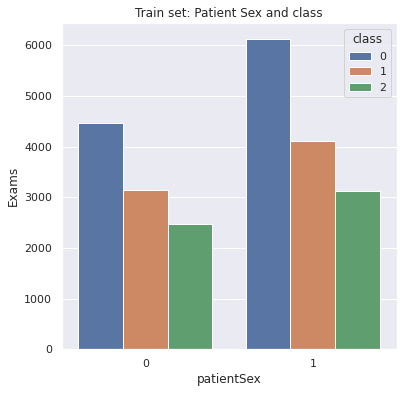

In [128]:
tmp = train_demo_df.groupby(['class', 'patientSex'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','class', 'patientSex']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, (ax) = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'patientSex', y='Exams', hue='class',data=df3)
plt.title("Train set: Patient Sex and class")
plt.show()

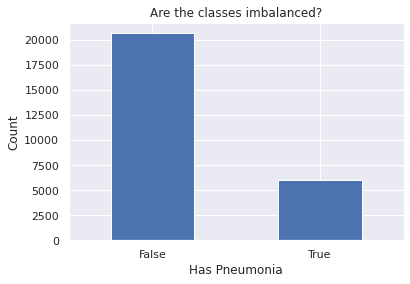

In [129]:
boxes_per_patient =train_labels_df.groupby('patientId')['Target'].sum()

ax = (boxes_per_patient > 0).value_counts().plot.bar()
_ = ax.set_title('Are the classes imbalanced?')
_ = ax.set_xlabel('Has Pneumonia')
_ = ax.set_ylabel('Count')
_ = ax.xaxis.set_tick_params(rotation=0)

##Finding out how many number of cases are there per Image 

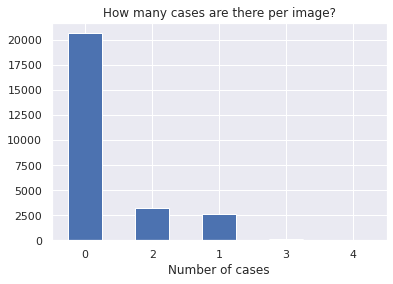

In [130]:
ax = boxes_per_patient.value_counts().plot.bar()
_ = ax.set_title('How many cases are there per image?')
_ = ax.set_xlabel('Number of cases')
_ = ax.xaxis.set_tick_params(rotation=0)

In [131]:
boxes_per_image = boxes_per_patient.value_counts() 
print (boxes_per_image)

0    20672
2     3266
1     2614
3      119
4       13
Name: Target, dtype: int64


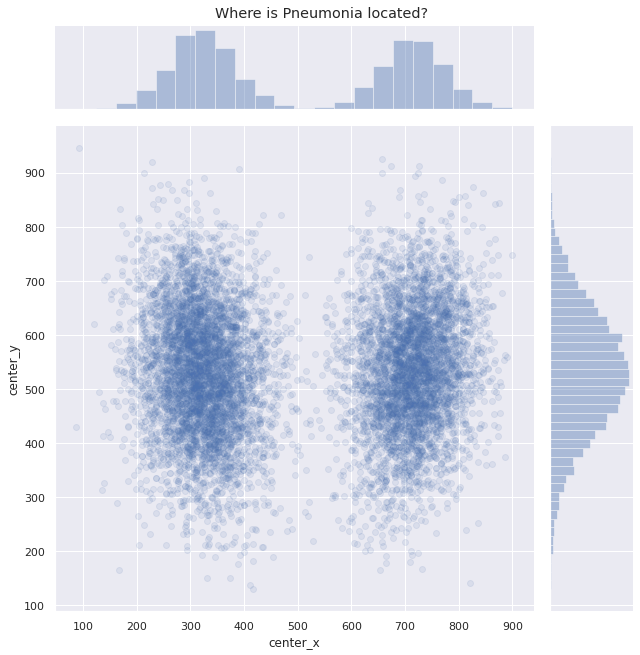

In [132]:
centers = (train_labels_df.dropna(subset=['x'])
           .assign(center_x=train_labels_df.x + train_labels_df.width / 2, center_y=train_labels_df.y + train_labels_df.height / 2))
ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.1)
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

In [133]:
df = train_demo_df.copy()
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18800 entries, 0 to 23459
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   18800 non-null  object 
 1   patientAge  18800 non-null  int64  
 2   patientSex  18800 non-null  int64  
 3   rows        18800 non-null  int64  
 4   cols        18800 non-null  int64  
 5   x           5947 non-null   float64
 6   y           5947 non-null   float64
 7   width       5947 non-null   float64
 8   height      5947 non-null   float64
 9   Target      18800 non-null  int64  
 10  class       18800 non-null  int64  
 11  age_group   0 non-null      float64
dtypes: float64(5), int64(6), object(1)
memory usage: 1.9+ MB


##Finding the Outliers

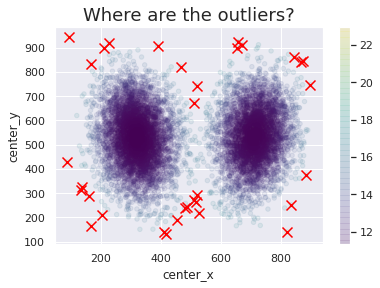

In [134]:
from sklearn.mixture import GaussianMixture
clf = GaussianMixture(n_components=2)
clf.fit(centers[['center_x', 'center_y']])
center_probs = clf.predict_proba(centers[['center_x', 'center_y']])
Z = -clf.score_samples(centers[['center_x', 'center_y']])
outliers = centers.iloc[Z > 17]
fig, ax = plt.subplots()
centers.plot.scatter('center_x', 'center_y', c=Z, alpha=0.1, cmap='viridis', ax=ax)
outliers.plot.scatter('center_x', 'center_y', c='red', marker='x', s=100, ax=ax)
_ = ax.set_title('Where are the outliers?', fontsize=18)

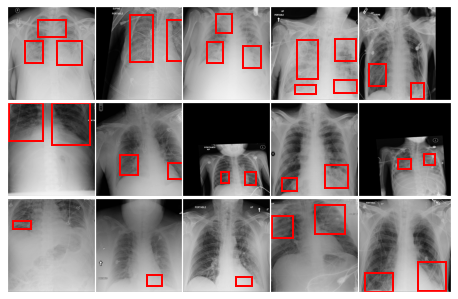

In [135]:
import matplotlib.patches as patches

def get_image(patientId, root_dir='/content/drive/My Drive/AIML/Datasets/stage_2_train_images/'):
    fn = os.path.join(root_dir, f'{patientId}.dcm')
    dcm_data = pydicom.read_file(fn)
    return dcm_data.pixel_array

def draw_bbs(bbs, ax):
    for bb in bbs.itertuples():
        rect = patches.Rectangle(
            (bb.x, bb.y), bb.width, bb.height,
            linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

def draw_image(img, bbs, ax):
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if bbs is not None:
        draw_bbs(bbs, ax)

outliers_15 = outliers.drop_duplicates(subset=['patientId']).iloc[:15]
fig, axes = plt.subplots(3, 5)
for row, ax in zip(outliers_15.itertuples(), axes.flatten()):
    img = get_image(row.patientId)
    bbs = train_labels_df.loc[train_labels_df.patientId == row.patientId, ['x', 'y', 'width', 'height']]
    draw_image(img, bbs, ax)
fig.tight_layout(pad=-0.5)

In [136]:
df_detailed = class_info_df
print(df_detailed.iloc[6])
print(df_detailed.iloc[80])


patientId    00569f44-917d-4c86-a842-81832af98c30
class                No Lung Opacity / Not Normal
Name: 6, dtype: object
patientId    01fa0f5e-00c3-41cb-b5c7-10600c8633ae
class                                Lung Opacity
Name: 80, dtype: object
